In [1]:
!pip install pandas numpy scipy scikit-learn hdbscan plotly chardet

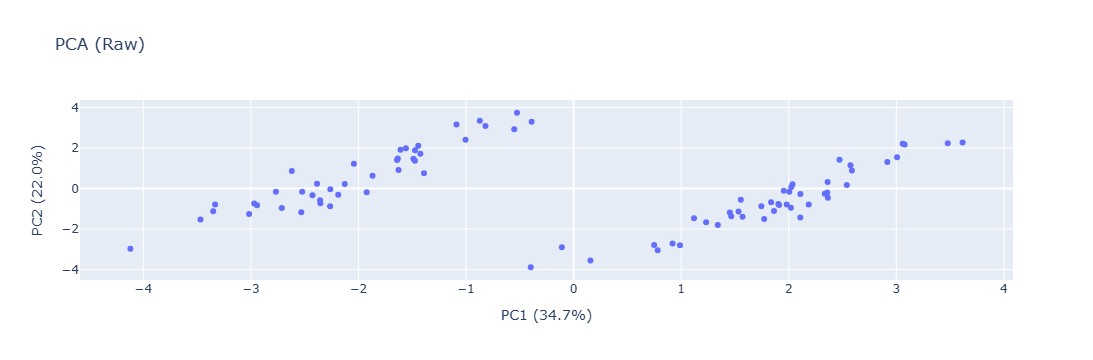

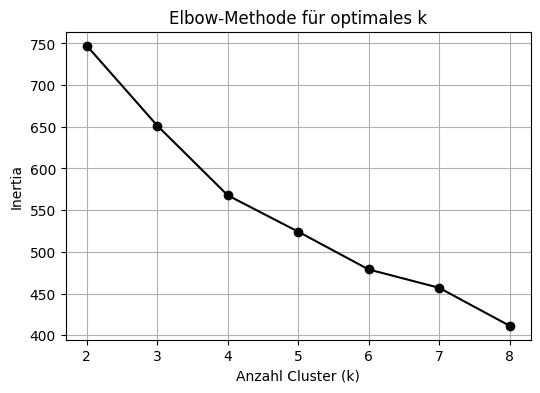

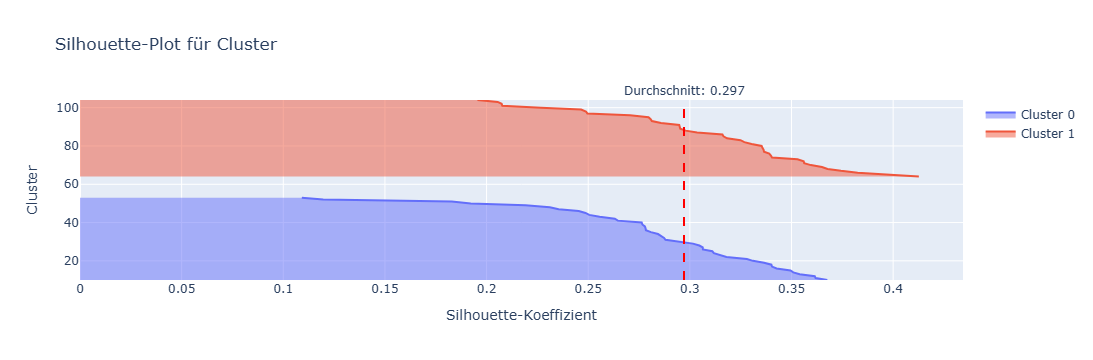

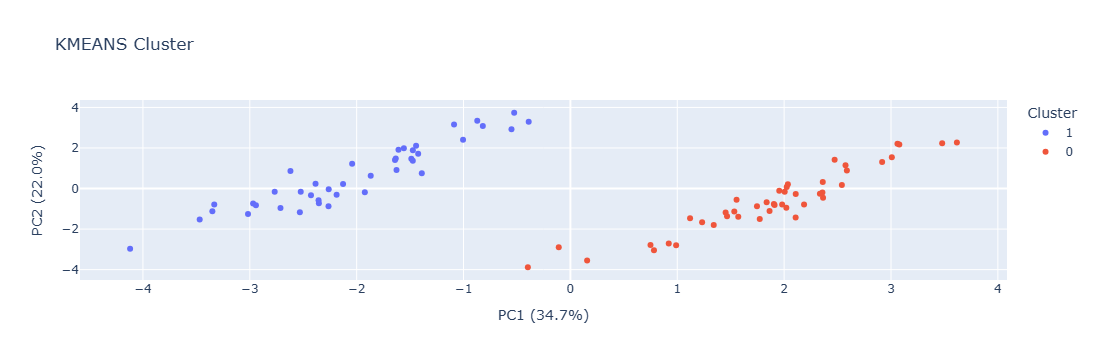

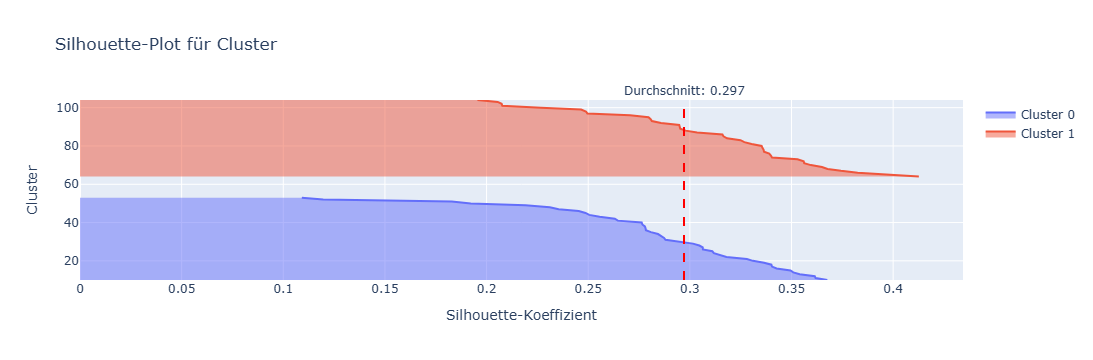

In [9]:
import os
import numpy as np
import pandas as pd
from scipy.stats import zscore
from sklearn.ensemble import IsolationForest
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from hdbscan import HDBSCAN
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import logging
import chardet

# Set up logging
logging.basicConfig(level=logging.INFO, filename='clustering_log.txt', format='%(asctime)s - %(levelname)s - %(message)s')

class BatchClustering:
    def __init__(self, data_dir, method="kmeans", n_clusters=3, var_threshold=0.90, min_components=2):
        self.data_dir = data_dir
        self.method = method.lower()
        self.n_clusters = n_clusters
        self.var_threshold = var_threshold
        self.min_components = min_components
        self.batches = {}  # raw DataFrames by batch
        self.features = None  # summary feature DataFrame
        self.clean_features = None
        self.scaler = StandardScaler()
        self.pca = PCA(n_components=var_threshold, svd_solver="auto", random_state=0)
        self.labels_ = None
        self.silhouette_scores_ = None
        logging.info(f"Initialized BatchClustering with parameters: {vars(self)}")

    def detect_encoding(self, file_path):
        """Erkennung der Dateikodierung"""
        try:
            with open(file_path, 'rb') as f:
                result = chardet.detect(f.read(10000))
            encoding = result['encoding'] or 'utf-8'
            logging.info(f"Erkannte Kodierung für {file_path}: {encoding}")
            return encoding
        except Exception as e:
            logging.error(f"Fehler bei der Kodierungserkennung für {file_path}: {e}")
            return 'utf-8'

    def load_batches(self):
        """Laden aller .txt-Dateien aus dem angegebenen Verzeichnis"""
        if not os.path.exists(self.data_dir):
            logging.error(f"Verzeichnis {self.data_dir} existiert nicht.")
            raise FileNotFoundError(f"Verzeichnis {self.data_dir} existiert nicht.")

        required_cols = ['c', 'T_PM', 'd10', 'd50', 'd90', 'T_TM', 'mf_PM', 'mf_TM', 
                        'Q_g', 'w_crystal', 'c_in', 'T_PM_in', 'T_TM_in']
        separators = ['\t', ',', ';', ' ']

        for file in os.listdir(self.data_dir):
            if not file.endswith(".txt"):
                continue
            file_path = os.path.join(self.data_dir, file)
            try:
                encoding = self.detect_encoding(file_path)
                with open(file_path, 'r', encoding=encoding, errors='ignore') as f:
                    first_lines = [f.readline().strip() for _ in range(5)]
                logging.info(f"Erste Zeilen von {file}: {first_lines}")

                df = None
                for sep in separators:
                    try:
                        df = pd.read_csv(file_path, sep=sep, encoding=encoding, skipinitialspace=True)
                        if len(df.columns) > 1:
                            logging.info(f"Erfolgreich geladen mit Trennzeichen '{sep}' für {file}")
                            break
                    except Exception as e:
                        logging.warning(f"Fehler mit Trennzeichen '{sep}' für {file}: {e}")
                
                if df is None or df.empty:
                    logging.warning(f"Datei {file} ist leer oder hat ein ungültiges Format.")
                    continue

                missing_cols = [col for col in required_cols if col not in df.columns]
                if missing_cols:
                    logging.warning(f"Datei {file} fehlt folgende Spalten: {missing_cols}")
                    continue

                if df.select_dtypes(include=np.number).empty:
                    logging.warning(f"Datei {file} enthält keine numerischen Daten.")
                    continue

                self.batches[file] = df
                logging.info(f"Geladen {file} mit Shape {df.shape}, Spalten: {list(df.columns)}")
            except Exception as e:
                logging.error(f"Fehler beim Laden von {file}: {e}")

        if not self.batches:
            logging.error("Keine gültigen Daten geladen.")
            raise ValueError("Keine gültigen Daten geladen.")

    def extract_features(self, steady_frac: float = 1.0):
        """Extrahieren von Features aus jeder Batch"""
        rows = []
        for name, df in self.batches.items():
            try:
                df = df.fillna(df.mean(numeric_only=True))
                n_ss = max(1, int(len(df) * steady_frac))
                ss = df.tail(n_ss)
                
                if ss['d50'].std() / ss['d50'].mean() > 0.1:
                    logging.warning(f"Batch {name} möglicherweise nicht im stabilen Zustand (hohe Varianz in d50)")

                feature_dict = {'batch': name}
                feature_dict['avg_d10'] = ss['d10'].mean()
                feature_dict['avg_d50'] = ss['d50'].mean()
                feature_dict['avg_d90'] = ss['d90'].mean()
                feature_dict['avg_c'] = ss['c'].mean()
                feature_dict['avg_T_PM'] = ss['T_PM'].mean()
                feature_dict['avg_T_TM'] = ss['T_TM'].mean()
                feature_dict['avg_mf_PM'] = df['mf_PM'].mean()
                feature_dict['avg_mf_TM'] = df['mf_TM'].mean()
                feature_dict['avg_Q_g'] = df['Q_g'].mean()
                feature_dict['avg_w_crystal'] = df['w_crystal'].mean()
                feature_dict['avg_c_in'] = df['c_in'].mean()
                feature_dict['avg_T_PM_in'] = df['T_PM_in'].mean()
                feature_dict['avg_T_TM_in'] = df['T_TM_in'].mean()
                rows.append(feature_dict)
            except Exception as e:
                logging.error(f"Fehler beim Extrahieren von Features aus {name}: {e}")

        self.features = pd.DataFrame(rows)
        self.clean_features = self.features.copy()
        logging.info(f"Features für {len(self.features)} Batches extrahiert")

    def remove_outliers(self, z_thresh=3.0, iso_frac=0.05):
        """Entfernen von Ausreißern mit Z-Score und Isolation Forest"""
        df = self.clean_features.copy()
        try:
            df_z = df.drop(columns=['batch']).apply(zscore)
            mask_z = (np.abs(df_z) < z_thresh).all(axis=1)
            df = df[mask_z]
            logging.info(f"{len(self.clean_features) - len(df)} Ausreißer mit Z-Score entfernt")

            iso = IsolationForest(contamination=iso_frac, random_state=0)
            iso_mask = iso.fit_predict(df.drop(columns=['batch'])) == 1
            df = df[iso_mask]
            logging.info(f"{len(self.clean_features) - len(df)} Ausreißer mit Isolation Forest entfernt")

            removed = self.features[~self.features['batch'].isin(df['batch'])]['batch']
            logging.info(f"Entfernte Batches als Ausreißer: {removed.tolist()}")
            self.clean_features = df
            return df
        except Exception as e:
            logging.error(f"Fehler beim Entfernen von Ausreißern: {e}")
            return self.clean_features

    def prepare(self):
        """Daten für Clustering vorbereiten"""
        try:
            X = self.clean_features.drop(columns=['batch']).values
            self.X_scaled = self.scaler.fit_transform(X)
            logging.info(f"Daten skaliert mit Shape {self.X_scaled.shape}")
        except Exception as e:
            logging.error(f"Fehler bei der Datenaufbereitung: {e}")

    def run_pca(self, show=True):
        """PCA anwenden und Ergebnisse visualisieren"""
        try:
            n_components = max(self.min_components, int(self.var_threshold * self.X_scaled.shape[1]))
            self.pca.n_components = n_components
            self.X_use = self.pca.fit_transform(self.X_scaled)
            var_sum = self.pca.explained_variance_ratio_.sum() * 100
            logging.info(f"PCA behielt {self.X_use.shape[1]} Komponenten (kumulative Varianz {var_sum:.1f}%)")

            if show and self.X_use.shape[1] >= 2:
                fig = px.scatter(
                    x=self.X_use[:, 0], y=self.X_use[:, 1],
                    labels={'x': f'PC1 ({self.pca.explained_variance_ratio_[0]*100:.1f}%)',
                            'y': f'PC2 ({self.pca.explained_variance_ratio_[1]*100:.1f}%)'},
                    title="PCA (Raw)"
                )
                fig.show()
            elif show and self.X_use.shape[1] >= 3:
                fig = px.scatter_3d(
                    x=self.X_use[:, 0], y=self.X_use[:, 1], z=self.X_use[:, 2],
                    labels={'x': f'PC1 ({self.pca.explained_variance_ratio_[0]*100:.1f}%)',
                            'y': f'PC2 ({self.pca.explained_variance_ratio_[1]*100:.1f}%)',
                            'z': f'PC3 ({self.pca.explained_variance_ratio_[2]*100:.1f}%)'},
                    title="PCA (3D Raw)"
                )
                fig.show()

            return self.X_use
        except Exception as e:
            logging.error(f"Fehler beim Ausführen von PCA: {e}")
            return None

    def find_k(self, max_k=10, show_elbow=True):
        """Optimale Anzahl an Clustern finden"""
        try:
            Ks = range(2, max_k + 1)
            inertias, silhs = [], []
            for k in Ks:
                km = KMeans(n_clusters=k, random_state=0, n_init=10)
                lbl = km.fit_predict(self.X_use)
                inertias.append(km.inertia_)
                silhs.append(silhouette_score(self.X_use, lbl))
            
            best_k = Ks[np.argmax(silhs)]
            logging.info(f"Bester k = {best_k}, Silhouette = {max(silhs):.3f}")

            if show_elbow:
                plt.figure(figsize=(6, 4))
                plt.plot(Ks, inertias, 'o-k')
                plt.xlabel('Anzahl Cluster (k)')
                plt.ylabel('Inertia')
                plt.title('Elbow-Methode für optimales k')
                plt.grid(True)
                plt.show()

            return best_k
        except Exception as e:
            logging.error(f"Fehler beim Finden von k: {e}")
            return None

    def compute_silhouette_per_cluster(self):
        """Silhouette-Score pro Cluster berechnen"""
        try:
            if len(set(self.labels_)) <= 1 or (-1 in self.labels_ and len(set(self.labels_)) <= 2):
                logging.warning("Zu wenige Cluster für Silhouette-Score-Berechnung")
                return None

            self.silhouette_scores_ = silhouette_samples(self.X_use, self.labels_)
            cluster_silhouettes = {}
            for cluster_id in np.unique(self.labels_):
                if cluster_id == -1:
                    continue
                mask = self.labels_ == cluster_id
                cluster_silhouettes[cluster_id] = np.mean(self.silhouette_scores_[mask])
                logging.info(f"Silhouette-Score für Cluster {cluster_id}: {cluster_silhouettes[cluster_id]:.3f}")

            sil_avg = silhouette_score(self.X_use, self.labels_)
            logging.info(f"Durchschnittlicher Silhouette-Score: {sil_avg:.3f}")
            return cluster_silhouettes, sil_avg
        except Exception as e:
            logging.error(f"Fehler beim Berechnen des Silhouette-Scores: {e}")
            return None

    def cluster(self):
        """Clustering mit der angegebenen Methode durchführen"""
        try:
            if self.method == "kmeans":
                model = KMeans(n_clusters=self.n_clusters, random_state=0, n_init=10)
                self.labels_ = model.fit_predict(self.X_use)
            elif self.method == "dbscan":
                model = DBSCAN(eps=0.5, min_samples=5)
                self.labels_ = model.fit_predict(self.X_use)
            elif self.method == "hdbscan":
                model = HDBSCAN(min_cluster_size=5)
                self.labels_ = model.fit_predict(self.X_use)
            else:
                logging.error(f"Unbekannte Methode: {self.method}")
                raise ValueError(f"Unbekannte Methode: {self.method}")

            self.clean_features['cluster'] = self.labels_
            ncl = len(set(self.labels_)) - (1 if -1 in self.labels_ else 0)
            if ncl > 1:
                sil_avg = silhouette_score(self.X_use, self.labels_)
                logging.info(f"{self.method.upper()}: {ncl} Cluster, durchschnittlicher Silhouette-Score={sil_avg:.3f}")
                self.compute_silhouette_per_cluster()
                self.plot_silhouette()
            else:
                logging.warning("Zu wenige Cluster für Silhouette-Score-Berechnung")

            return self.labels_
        except Exception as e:
            logging.error(f"Fehler beim Clustering: {e}")
            return None

    def plot_silhouette(self):
        """Silhouette-Plot für Cluster erstellen"""
        try:
            if self.silhouette_scores_ is None or len(set(self.labels_)) <= 1:
                logging.warning("Keine Silhouette-Scores verfügbar oder zu wenige Cluster")
                return

            fig = go.Figure()
            y_lower = 10
            unique_labels = sorted([lbl for lbl in np.unique(self.labels_) if lbl != -1])
            for cluster_id in unique_labels:
                mask = self.labels_ == cluster_id
                cluster_scores = np.sort(self.silhouette_scores_[mask])[::-1]
                y_upper = y_lower + len(cluster_scores)
                fig.add_trace(go.Scatter(
                    x=cluster_scores,
                    y=np.arange(y_lower, y_upper),
                    mode='lines',
                    fill='tozerox',
                    name=f'Cluster {cluster_id}',
                    text=[f'Cluster {cluster_id}' for _ in cluster_scores]
                ))
                y_lower = y_upper + 10

            avg_score = silhouette_score(self.X_use, self.labels_)
            fig.add_vline(x=avg_score, line_dash="dash", line_color="red", 
                          annotation_text=f"Durchschnitt: {avg_score:.3f}", annotation_position="top")
            fig.update_layout(
                title="Silhouette-Plot für Cluster",
                xaxis_title="Silhouette-Koeffizient",
                yaxis_title="Cluster",
                showlegend=True
            )
            fig.show()
        except Exception as e:
            logging.error(f"Fehler beim Erstellen des Silhouette-Plots: {e}")

    def plot_clusters(self):
        """Cluster im PCA-Raum visualisieren"""
        try:
            pcs = self.X_use
            labels = self.labels_
            fig = px.scatter(
                x=pcs[:, 0], y=pcs[:, 1], color=labels.astype(str),
                labels={'x': f'PC1 ({self.pca.explained_variance_ratio_[0]*100:.1f}%)',
                        'y': f'PC2 ({self.pca.explained_variance_ratio_[1]*100:.1f}%)'},
                title=f"{self.method.upper()} Cluster"
            )
            fig.update_layout(legend_title="Cluster")
            fig.show()
        except Exception as e:
            logging.error(f"Fehler beim Plotten der Cluster: {e}")

    def get_cluster_assignments(self):
        """Cluster-Zuweisungen mit Silhouette-Scores ausgeben"""
        try:
            cluster_dict = {}
            for cluster_id in np.unique(self.labels_):
                mask = self.clean_features['cluster'] == cluster_id
                batch_names = self.clean_features.loc[mask, 'batch'].tolist()
                cluster_dict[cluster_id] = batch_names

            logging.info("=== Cluster-Zuweisungen ===")
            for cluster_id, batches in sorted(cluster_dict.items()):
                logging.info(f"Cluster {cluster_id}: {len(batches)} Batches")
                examples = batches[:3] + (["..."] if len(batches) > 3 else [])
                logging.info(f"  Beispiele: {examples}")
                if self.silhouette_scores_ is not None and cluster_id != -1:
                    mask = self.labels_ == cluster_id
                    sil_score = np.mean(self.silhouette_scores_[mask])
                    logging.info(f"  Silhouette-Score: {sil_score:.3f}")

            return cluster_dict
        except Exception as e:
            logging.error(f"Fehler beim Abrufen der Cluster-Zuweisungen: {e}")
            return None

if __name__ == "__main__":
    try:
        bc = BatchClustering(
            data_dir="Data",
            method="kmeans",
            n_clusters=2,
            var_threshold=0.90,
            min_components=2
        )
        bc.load_batches()
        bc.extract_features(steady_frac=1.0)
        bc.remove_outliers(z_thresh=3.0, iso_frac=0.05)
        bc.prepare()
        bc.run_pca(show=True)
        if bc.method == "kmeans":
            bc.n_clusters = bc.find_k(max_k=8)
        bc.cluster()
        bc.plot_clusters()
        bc.plot_silhouette()
        bc.get_cluster_assignments()
    except Exception as e:
        logging.error(f"Fehler in der Hauptausführung: {e}")

In [20]:
# cluster_narx_trainer.py

import os
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import Huber
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import random
from tensorflow.keras.regularizers import l2

class ClusterNARXTrainer:
    def __init__(self, batch_clustering, cluster_id=0, n_steps=5):
        self.bc = batch_clustering
        self.cluster_id = cluster_id
        self.n_steps = n_steps
        self.model = None
        self.scaler_x = MinMaxScaler()
        self.scaler_y = MinMaxScaler()

    def get_cluster_batches(self):
        cluster_files = self.bc.clean_features[
            self.bc.clean_features['cluster'] == self.cluster_id]['batch'].tolist()
        return [self.bc.batches[f] for f in cluster_files if f in self.bc.batches]

    def split_files(self, files, train_frac=0.9):
        random.shuffle(files)
        split_idx = int(len(files) * train_frac)
        return files[:split_idx], files[split_idx:]

    def prepare_sequences(self, files):
        X_list, y_list = [], []
        for df in files:
            df = df.reset_index(drop=True)
            inputs = df[['mf_PM', 'mf_TM', 'Q_g', 'w_crystal', 'c_in', 'T_PM_in', 'T_TM_in']]
            targets = df[['T_PM', 'c', 'd10', 'd50', 'd90', 'T_TM']]

            x_scaled = pd.DataFrame(self.scaler_x.transform(inputs), columns=inputs.columns)
            y_scaled = pd.DataFrame(self.scaler_y.transform(targets), columns=targets.columns)

            for t in range(len(x_scaled) - self.n_steps):
                x_seq = x_scaled.iloc[t:t+self.n_steps].values
                y_target = y_scaled.iloc[t+self.n_steps].values
                X_list.append(x_seq)
                y_list.append(y_target)

        return np.array(X_list), np.array(y_list)

    def build_model(self):
        model = Sequential([
            LSTM(128, activation='tanh', return_sequences=True, input_shape=(self.n_steps, 7)),
            BatchNormalization(),
            Dropout(0.5),
            LSTM(64),
            BatchNormalization(),
            Dropout(0.5),
            Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
            Dense(6)
        ])
        model.compile(optimizer=Adam(learning_rate=0.0001),
                      loss=Huber(),
                      metrics=['mae'])
        self.model = model

    def train_model(self, X_train, y_train, X_val, y_val):
        early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
        history = self.model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=300,
            batch_size=32,
            callbacks=[early_stop],
            verbose=1
        )
        return history

    def evaluate_and_plot(self, X_test, y_test, history):
        preds = self.model.predict(X_test)
        y_test_inv = self.scaler_y.inverse_transform(y_test)
        preds_inv = self.scaler_y.inverse_transform(preds)

        # d50
        plt.figure(figsize=(10, 4))
        plt.plot(y_test_inv[:1000, 3], label='Actual d50')
        plt.plot(preds_inv[:1000, 3], label='Predicted d50', linestyle='--')
        plt.title("Prediction vs Actual - d50")
        plt.xlabel("Time Step")
        plt.ylabel("d50")
        plt.legend()
        plt.grid()
        plt.show()

        # d10
        plt.figure(figsize=(10, 4))
        plt.plot(y_test_inv[:1000, 2], label='Actual d10')
        plt.plot(preds_inv[:1000, 2], label='Predicted d10', linestyle='--')
        plt.title("Prediction vs Actual - d10")
        plt.xlabel("Time Step")
        plt.ylabel("d10")
        plt.legend()
        plt.grid()
        plt.show()

        # d90
        plt.figure(figsize=(10, 4))
        plt.plot(y_test_inv[:1000, 4], label='Actual d90')
        plt.plot(preds_inv[:1000, 4], label='Predicted d90', linestyle='--')
        plt.title("Prediction vs Actual - d90")
        plt.xlabel("Time Step")
        plt.ylabel("d90")
        plt.legend()
        plt.grid()
        plt.show()

        # Overfitting plot
        plt.figure(figsize=(10, 4))
        plt.plot(history.history['loss'], label='Training Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.title("Training vs Validation Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()
        plt.grid()
        plt.show()

    def run(self):
        cluster_batches = self.get_cluster_batches()
        print(f"📦 Cluster {self.cluster_id}: {len(cluster_batches)} files")

        # Fit scalers on all data
        all_df = pd.concat(cluster_batches, ignore_index=True)
        self.scaler_x.fit(all_df[['mf_PM', 'mf_TM', 'Q_g', 'w_crystal', 'c_in', 'T_PM_in', 'T_TM_in']])
        self.scaler_y.fit(all_df[['T_PM', 'c', 'd10', 'd50', 'd90', 'T_TM']])

        # Split files
        train_files, val_files = self.split_files(cluster_batches, train_frac=0.9)

        # Prepare sequences
        X_train, y_train = self.prepare_sequences(train_files)
        X_val, y_val = self.prepare_sequences(val_files)

        # Build and train model
        self.build_model()
        history = self.train_model(X_train, y_train, X_val, y_val)

        # Evaluation
        self.evaluate_and_plot(X_val, y_val, history)

        return history

📦 Cluster 0: 44 files
Epoch 1/300


C:\Users\Abualrejal\anaconda3\envs\PAS\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



1213/1213 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - loss: 0.3842 - mae: 0.6595 - val_loss: 0.0808 - val_mae: 0.1977
Epoch 2/300
1213/1213 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - loss: 0.1089 - mae: 0.2722 - val_loss: 0.0556 - val_mae: 0.1348
Epoch 3/300
1213/1213 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - loss: 0.0680 - mae: 0.1868 - val_loss: 0.0417 - val_mae: 0.1070
Epoch 4/300
1213/1213 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 0.0457 - mae: 0.1364 - val_loss: 0.0292 - val_mae: 0.0830
Epoch 5/300
1213/1213 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 0.0297 - mae: 0.0990 - val_loss: 0.0183 - val_mae: 0.0600
Epoch 6/300
1213/1213 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - loss: 0.0178 - mae: 0.0710 - val_loss: 0.0102 - val_mae: 0.0444
Epoch 7/300
1213/1213 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - loss: 0.0096 - mae: 0.0508 - val_loss: 0.0046 - val_mae: 0.0270
Epoch 8/300
1213/1213 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - loss: 0.0046 - mae: 0.0364 - val_loss: 0.0019 - val_mae: 0.0175
Epoch 9/300
1213/1213 ━━━━━━━━━━━━━━━━━━━━ 

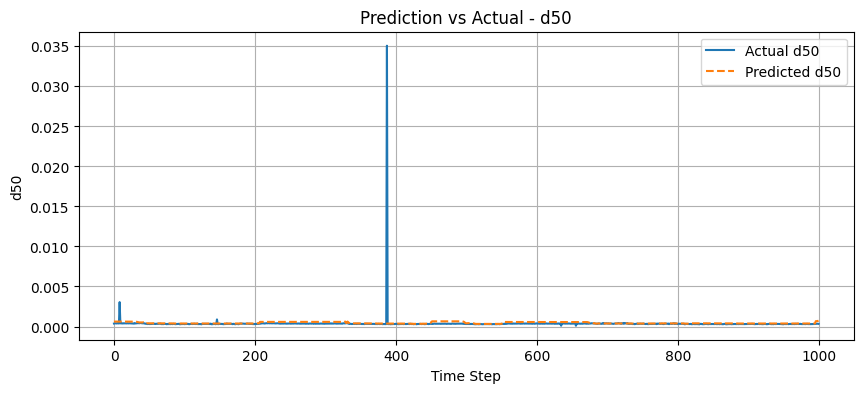

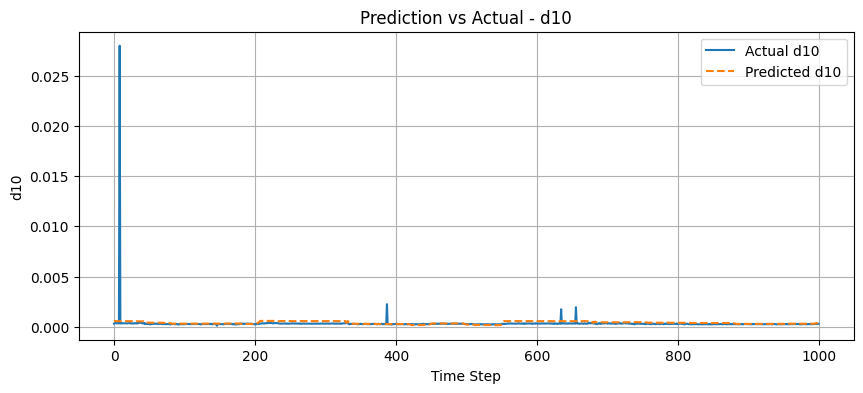

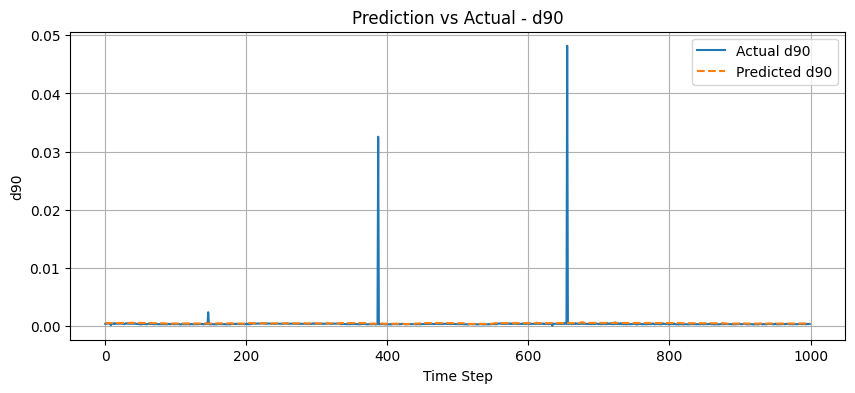

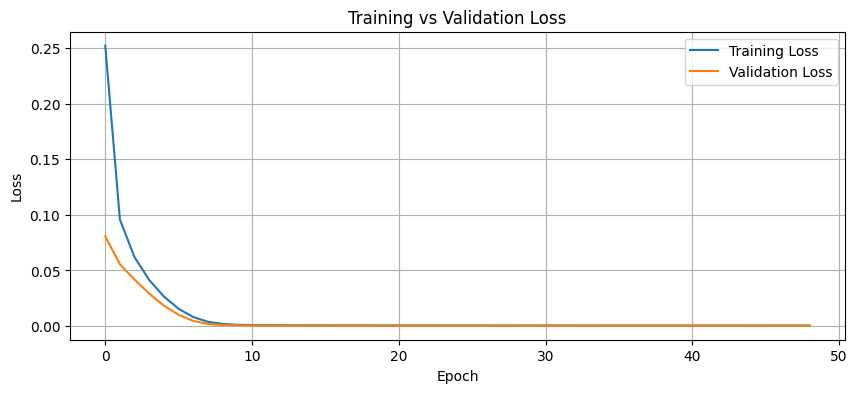

In [21]:
trainer = ClusterNARXTrainer(batch_clustering=bc, cluster_id=0)
trainer.run()

In [22]:
print(f"Nach Outlier-Filter: {len(bc.clean_features)} Batches")


Nach Outlier-Filter: 85 Batches
